<a href="https://colab.research.google.com/github/iamviji/project/blob/master/PostMidTerm/Experiment/Keras_50_100_50_skip_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy
import time
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, GaussianNoise
from tensorflow.keras import Model
from keras.layers.normalization import BatchNormalization


#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior ()

input_message_length = 50
encoder_output_length = 100
channel_size = 50
NUM_OF_INPUT_MESSAGE = 100000
SNR_STEP_SIZE = .5

SNR_BEGIN = 0
SNR_END = 10

bler_per_iter_uncoded_commpy_psk_2= [0.521, 0.473, 0.436, 0.37,  0.304, 0.259, 0.187, 0.138, 0.098, 0.098, 0.052, 0.028, 0.012, 0.011, 0.009, 0.002, 0.0,  0.001, 0.,    0.0]
bler_per_iter_uncoded_itpp_psk_2= [0.518, 0.478, 0.415, 0.355, 0.305, 0.227, 0.177, 0.149, 0.11,  0.075, 0.055, 0.023, 0.014, 0.014, 0.015, 0.001, 0.003, 0.001, 0.,    0. ]
bler_per_iter_uncoded_commpy_psk_4 = [0.815, 0.793, 0.75,  0.714, 0.64,  0.639, 0.526, 0.49,  0.433, 0.371, 0.335, 0.236, 0.204, 0.154, 0.129, 0.08,  0.063, 0.046, 0.023, 0.018]
bler_per_iter_uncoded_itpp_psk_4 = [0.814, 0.767, 0.729, 0.702, 0.66,  0.616, 0.563, 0.511, 0.442, 0.4,   0.294, 0.277, 0.228, 0.17,  0.114, 0.087, 0.05,  0.037, 0.022, 0.017]
bler_per_iter_ldpc_itpp_psk_4 = [0.584, 0.488, 0.404, 0.332, 0.218, 0.151, 0.097, 0.058, 0.041, 0.024, 0.007, 0.004, 0.002, 0.001, 0.001, 0.,    0.,    0.,    0.,    0.,   ]
bler_per_iter_ham_itpp_psk_4= [0.51, 0.479, 0.419, 0.333, 0.313, 0.247, 0.212, 0.132, 0.114, 0.093, 0.042, 0.027, 0.024, 0.016, 0.006, 0.005, 0.003, 0.002, 0.,    0.  ]
bler_per_iter_ldpc_50_100_itpp_psk_4 = [1., 1., 0.997, 0.989, 0.92,  0.697, 0.391, 0.123, 0.042, 0.011, 0.,    0.,  0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]
bler_per_iter_uncoded_100_itpp_psk_4 = [1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    0.997, 0.991, 0.97,  0.948, 0.924, 0.821, 0.74,  0.566, 0.444, 0.296, 0.211, 0.136]
bler_per_iter_uncoded_50_itpp_psk_4 = [1.,    1.,    1.,    1.,    .998,    .986,    .987,    0.974, 0.936, 0.912,  0.859, 0.785, 0.7, 0.602,  0.488, 0.329, 0.255, 0.168, 0.125, 0.061]
bler_per_iter_uncoded_50_itpp_psk_2 = [0.982, 0.964, 0.94,  0.9,   0.861, 0.773, 0.682, 0.565, 0.478, 0.359, 0.248, 0.169, 0.105, 0.074, 0.037, 0.016, 0.011, 0.003, 0.001, 0.   ]
bler_per_iter_uncoded_100_itpp_psk_2 = [0.999, 0.999, 0.995, 0.992, 0.975, 0.939, 0.898, 0.841, 0.72,  0.57,  0.44,  0.312, 0.209, 0.131, 0.071, 0.036, 0.017, 0.013, 0.003, 0.002]



def Snr2Sigma(snr):
  sigma = 10 ** (- snr / 20)
  return sigma


def timer_update(i,current,time_tot,tic_incr=500):
    last = current
    current = time.time()
    t_diff = current-last
    print('SNR: {:04.3f} - Iter: {} - Last {} iterations took {:03.2f}s'.format(snr,i+1,tic_incr,t_diff))
    return time_tot + t_diff


In [6]:

from keras import backend as K

#awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [2*channel_size])
#awgn_noise_std_dev = tf.placeholder(tf.float64)
#awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
#awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)


#decoder_input_x = tf.placeholder("float32", [None, input_message_length], name="decoder_input_x")

snr_std = -100

def my_loss(y_true, y_pred):
  #tf.reduce_mean (-1 * (y_true*tf.log(y_pred) + (1 - y_true)*tf.log(1 - y_pred) ))
  tf.reduce_mean ((tf.reduce_sum(tf.square(y_true-y_pred), axis=1)))

def custom_loss_function(y_true, y_pred):
   squared_difference = tf.square(y_true - y_pred)
   return tf.reduce_mean(squared_difference, axis=-1)

def _loss_tensor(y_true, y_pred):
    print (y_true)
    #y_true_x = tf.cast(y_true, dtype=tf.float32)
    #y_pred_x = tf.cast(y_pred, dtype=tf.float32)
    #out = -(y_true_x * K.log(y_pred_x) + (1.0 - y_true_x) * K.log(1.0 - y_pred_x))
    out = -(y_true * K.log(y_pred) + (1.0 - y_true) * K.log(1.0 - y_pred))
    return K.mean(out, axis=-1)

input_message_x = Input(shape=(input_message_length,))
# "encoded" is the encoded representation of the input
enc_layer11 = Dense(encoder_output_length, activation='tanh')(input_message_x)
enc_layer12 = Dense(encoder_output_length, activation='tanh')(enc_layer11)
enc_layer13 = enc_layer11 + enc_layer12
enc_layer14 = Dense(encoder_output_length, activation='tanh')(enc_layer13)
enc_layer2 = Dense(2*channel_size, activation='tanh')(enc_layer14)
enc_layer3 =  enc_layer2 / tf.sqrt(tf.reduce_mean(tf.square(enc_layer2)))
encoder = Model(input_message_x, enc_layer3)

awgn_channel = GaussianNoise(Snr2Sigma(snr_std),input_shape=(2*channel_size,))

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(2*channel_size,))
dec_layer1 = Dense(encoder_output_length, activation='tanh')(encoded_input)
dec_layer2 = Dense(input_message_length, activation="sigmoid")(dec_layer1)
# this model maps an encoded input to its decoder representation
decoder = Model(encoded_input, dec_layer2)

# this model maps an input to its reconstruction
autoencoder = Model(input_message_x, decoder(awgn_channel(encoder(input_message_x))))

#decoder_output = (tf.nn.sigmoid(decoder_input_x))

print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 100)          5100        input_3[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 100)          10100       dense_5[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_AddV2_1 (TensorFlow multiple             0           dense_5[0][0]                    
                                                                 dense_6[0][0]         

In [7]:
training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
training_input_message = tf.cast(training_input_message, dtype=tf.float32)
#training_input_message_label = training_input_message.reshape(,1)
#training_input_message_label = []
#= training_input_message.reshape(training_input_message.shape[NUM_OF_INPUT_MESSAGE*10])
#for i in range (NUM_OF_INPUT_MESSAGE*10):
#  training_input_message_label.append (training_input_message[i][0])
print (training_input_message)
print (len(training_input_message))
print ('x')
#print (training_input_message_label)
print(input_message_length)

tf.Tensor(
[[1. 0. 1. ... 0. 0. 1.]
 [0. 0. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 0. 1. 0.]
 ...
 [1. 0. 0. ... 0. 0. 1.]
 [1. 0. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]], shape=(1000000, 50), dtype=float32)
1000000
x
50


In [8]:
test_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
test_input_message = tf.cast(test_input_message, dtype=tf.float32)
test_input_message_label = []
for i in range (NUM_OF_INPUT_MESSAGE*10):
  test_input_message_label.append (test_input_message[i][0])
print (test_input_message)
print (len(test_input_message))

tf.Tensor(
[[1. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 1. 0. ... 1. 0. 1.]
 ...
 [1. 0. 1. ... 0. 1. 0.]
 [1. 0. 1. ... 1. 1. 1.]
 [0. 1. 0. ... 0. 0. 1.]], shape=(1000000, 50), dtype=float32)
1000000


In [9]:
import keras

#def custom_losff_fucntion (act, pred):
#  return (tf.reduce_mean(-1*(act * tf.log(pred) + (1-act)*tf.log(1-pred))))

opt = keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
#autoencoder.compile(optimizer=opt, loss=custom_losff_fucntion)
#loss='mean_squared_error'
#for snr in (numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)):
for snr in (numpy.arange (0, 10, SNR_STEP_SIZE)):
  sigma = 1.0*Snr2Sigma (snr)
  snr_std = sigma
  print ("Training for SNR=", snr, " sigma=", sigma) 
  awgn_channel = GaussianNoise(sigma,input_shape=(channel_size,))
  autoencoder = Model(input_message_x, decoder(awgn_channel(encoder(input_message_x))))
  #opt = keras.optimizers.Adam(learning_rate=0.003)
  #autoencoder.compile(optimizer=opt, loss=[tf.keras.losses.sparse_categorical_crossentropy],metrics=['accuracy'])
  autoencoder.compile(optimizer=opt, loss='mse',metrics=['accuracy'])
  autoencoder.fit(training_input_message, training_input_message,
                #epochs=50, original
                epochs=20,
                batch_size=5000,
                shuffle=False)#,
                #validation_data=(test_input_message_label, test_input_message_label))

Training for SNR= 0.0  sigma= 1.0
Epoch 1/20
200/200 [==============================] - 12s 62ms/step - loss: 0.1319 - accuracy: 0.0409
Epoch 2/20
200/200 [==============================] - 12s 62ms/step - loss: 0.0845 - accuracy: 0.0392
Epoch 3/20
200/200 [==============================] - 12s 62ms/step - loss: 0.0751 - accuracy: 0.0404
Epoch 4/20
200/200 [==============================] - 12s 62ms/step - loss: 0.0706 - accuracy: 0.0404
Epoch 5/20
200/200 [==============================] - 12s 61ms/step - loss: 0.0680 - accuracy: 0.0403
Epoch 6/20
200/200 [==============================] - 12s 62ms/step - loss: 0.0663 - accuracy: 0.0401
Epoch 7/20
200/200 [==============================] - 12s 62ms/step - loss: 0.0651 - accuracy: 0.0405
Epoch 8/20
200/200 [==============================] - 12s 62ms/step - loss: 0.0642 - accuracy: 0.0408
Epoch 9/20
200/200 [==============================] - 12s 62ms/step - loss: 0.0635 - accuracy: 0.0407
Epoch 10/20
200/200 [===========================

In [10]:
NUM_OF_INPUT_MESSAGE_BER = 600
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE_BER/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

#awgn_channel_tx = GaussianNoise(0.5,input_shape=(channel_size,))

#awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [channel_size])
#awgn_noise_std_dev = tf.placeholder(tf.float64)
#awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
#awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

#train_init = tf.global_variables_initializer ()
#train_sess = tf.Session ()
channel_in = []
channel_out = []
training_input_message_int = numpy.around(training_input_message).astype(int)
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  #awgn_channel = GaussianNoise(sigma,input_shape=(channel_size,))
  #autoencoder = Model(input_message_x, decoder(awgn_channel(encoder(input_message_x))))
  #opt = keras.optimizers.Adam(learning_rate=0.003)
  #autoencoder.compile(optimizer=opt, loss='binary_crossentropy')
  for i in range (NUM_OF_INPUT_MESSAGE_BER):
    input_message_xx = training_input_message [i:i+1]
    #print ("input", input_message_xx)
    encoded_message = encoder.predict(input_message_xx)
    channel_in.append(encoded_message[0])
    #encoded_message = numpy.around(encoded_message > 0.5).astype(int)
    #print("encoded:",encoded_message)
    #print ("encoded", encoded_message)
    #noised_message = awgn_channel.predict (encoded_message)
    #noised_message = commpy.channels.awgn(encoded_message, snr)
    #noised_message = train_sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message[0]})[0].reshape([1,2*channel_size])
    noised_message = encoded_message[0] + numpy.random.normal(0, sigma, [1,2*channel_size])
    channel_out.append(noised_message[0]) 
    #noised_message = encoded_message[0] + numpy.random.normal(0, sigma, [1,channel_size])
    #print (noised_message)
    #awgn_channel = GaussianNoise(sigma,input_shape=(channel_size,))
    #noised_message = awgn_channel.predict(encoded_message)
    #noised_message = awgn_layer (encoded_message)    
    #print(noised_message)
    decoded_message = decoder.predict(noised_message)
    #print ("decoded1:", decoded_message)
    #decoded_message = train_sess.run ([decoder_output], feed_dict={decoder_input_x:decoded_message})
    #print ("decoded2:", decoded_message)
    #decoded_message = autoencoder.predict(input_message_xx)
    decoded_message = numpy.around(decoded_message[0]).astype(int)
    #print ("decoded3:", decoded_message)
    #decoded_message = numpy.around(decoded_message > 0.5).astype(int)
    #print ("decoded:", decoded_message)
    #print (".")
    #autoencoder = Model(input_message_x, decoder(awgn_channel(encoder(input_message_x))))
    #decoded_message = autoencoder.predict(input_message_xx)
    #print ("output", decoded_message)
    #training_input_message_int = numpy.around(training_input_message[i]).astype(int)
    #tf.cast(training_input_message[i], dtype=tf.int32)
    #print (training_input_message_int)
    if abs(decoded_message-training_input_message_int[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
      #print ("Error")
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE_BER
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 150 - Last 150.0 iterations took 12.46s
SNR: 0.000 - Iter: 300 - Last 150.0 iterations took 24.91s
SNR: 0.000 - Iter: 450 - Last 150.0 iterations took 37.40s
SNR: 0.000 - Iter: 600 - Last 150.0 iterations took 50.91s
SNR: 0.000:
 -> BER: 0.99
 -> Total Time: 125.67s
SNR: 0.500 - Iter: 150 - Last 150.0 iterations took 12.60s
SNR: 0.500 - Iter: 300 - Last 150.0 iterations took 25.05s
SNR: 0.500 - Iter: 450 - Last 150.0 iterations took 37.43s
SNR: 0.500 - Iter: 600 - Last 150.0 iterations took 50.32s
SNR: 0.500:
 -> BER: 0.99
 -> Total Time: 125.40s
SNR: 1.000 - Iter: 150 - Last 150.0 iterations took 13.72s
SNR: 1.000 - Iter: 300 - Last 150.0 iterations took 27.53s
SNR: 1.000 - Iter: 450 - Last 150.0 iterations took 40.29s
SNR: 1.000 - Iter: 600 - Last 150.0 iterations took 52.43s
SNR: 1.000:
 -> BER: 0.95
 -> Total Time: 133.96s
SNR: 1.500 - Iter: 150 - Last 150.0 iterations took 12.14s
SNR: 1.500 - Iter: 300 - Last 150.0 iterations took 24.72s
SNR: 1.500 - Iter: 450 -

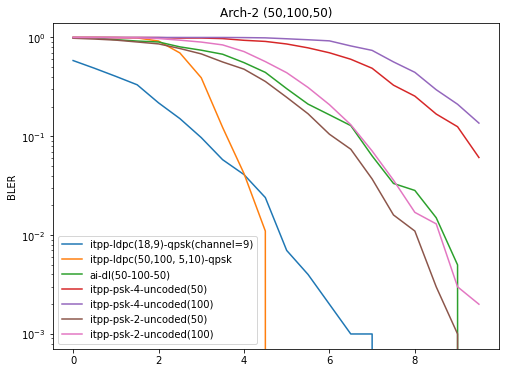

In [11]:
import matplotlib.pyplot as plt
#import numpy
%matplotlib inline
#ber_per_iter_dl_tensor = [.99,.98,.95,.93,.91,.83,.74,.66,.55,.46,.38,.26,.19,.10,.07,.05,.02,0.02,0.01,0.0]
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_4,'', label="itpp-ldpc(18,9)-qpsk(channel=9)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ldpc_50_100_itpp_psk_4,'', label="itpp-ldpc(50,100, 5,10)-qpsk") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl(50-100-50)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_50_itpp_psk_4,'', label="itpp-psk-4-uncoded(50)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_100_itpp_psk_4,'', label="itpp-psk-4-uncoded(100)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_50_itpp_psk_2,'', label="itpp-psk-2-uncoded(50)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_100_itpp_psk_2,'', label="itpp-psk-2-uncoded(100)") # plot BER vs SNR
#ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2,'', label="commpy-psk2-uncoded") # plot BER vs SNR
#ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="commpy-psk4-uncoded") # plot BER vs SNR
#ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="itpp-psk2-uncoded") # plot BER vs SNR
#ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham(7,4)(input=8,channel=7)") # plot BER vs SNR
ax1.set_ylabel('BLER')
ax1.set_title('Arch-2 ({},{},{})'.format(input_message_length,2*input_message_length, channel_size))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(2*channel_size,input_message_length))
plt.legend ()
plt.show()

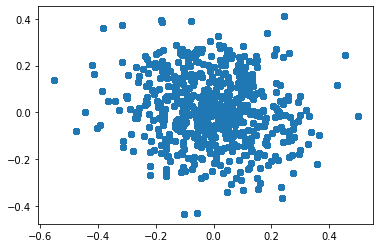

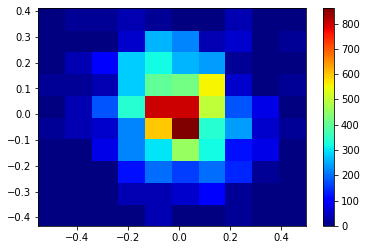

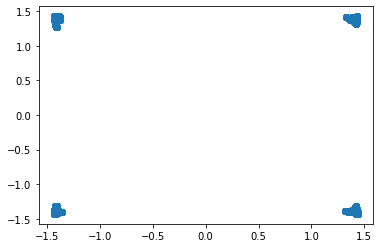

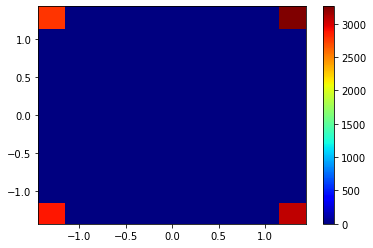

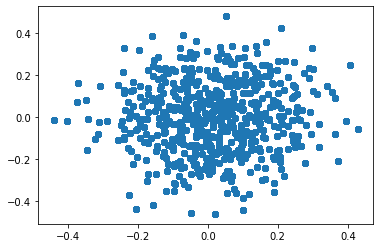

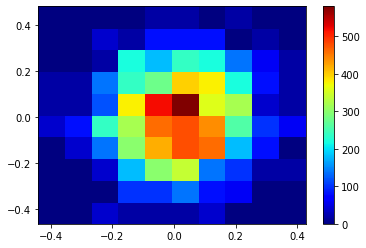

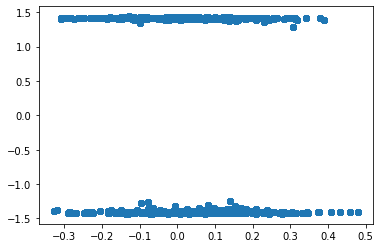

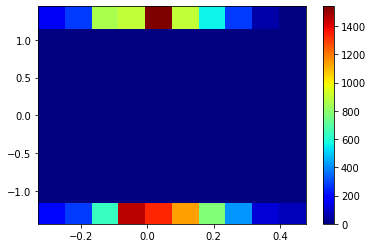

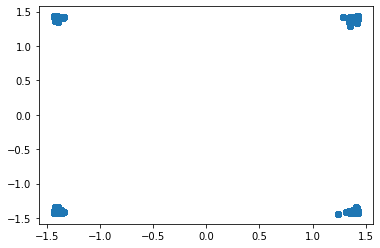

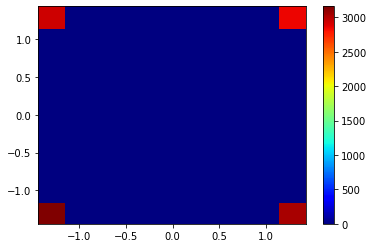

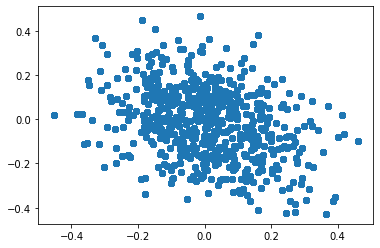

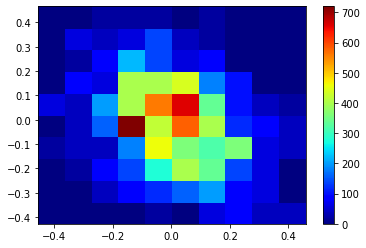

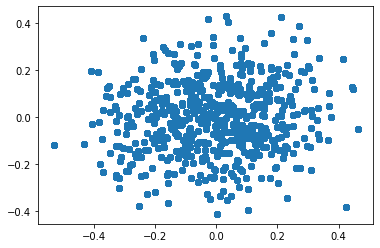

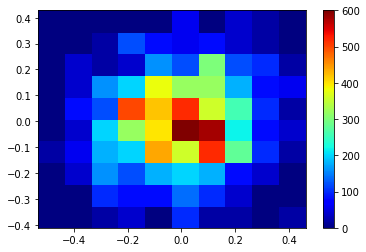

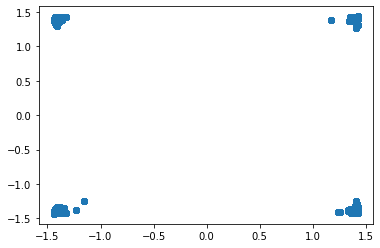

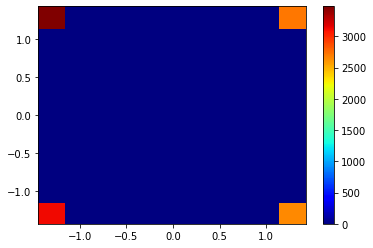

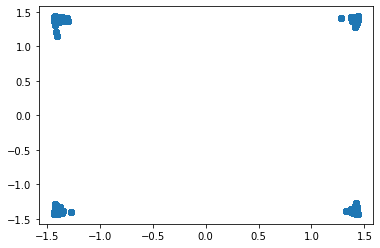

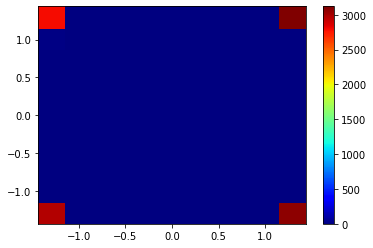

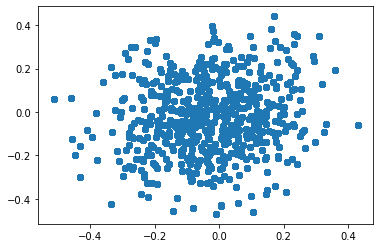

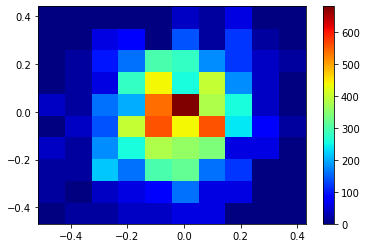

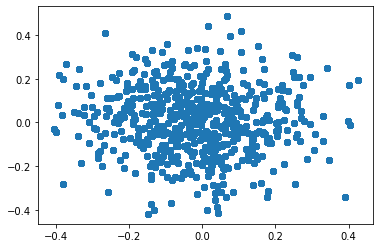

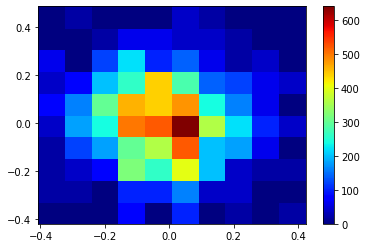

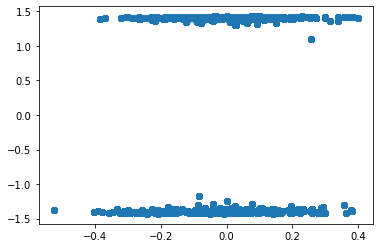

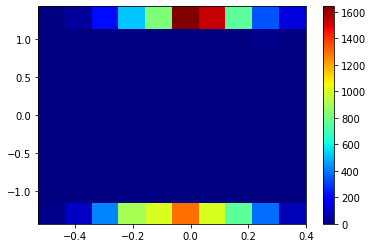

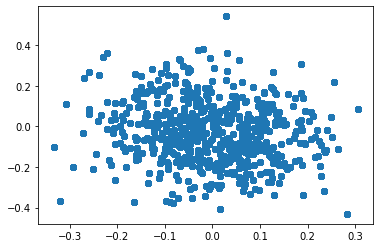

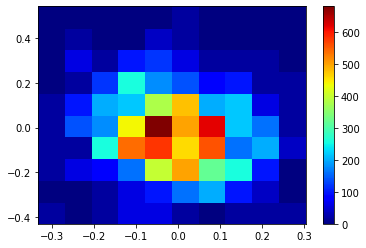

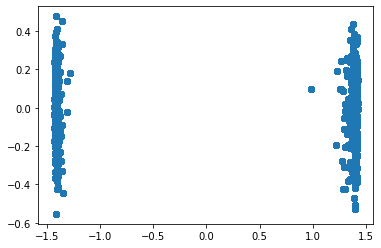

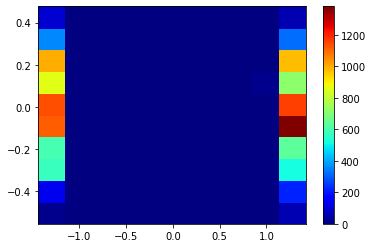

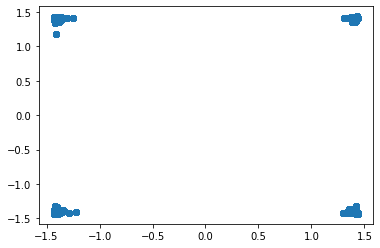

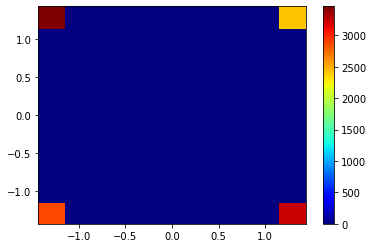

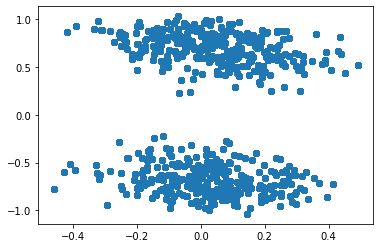

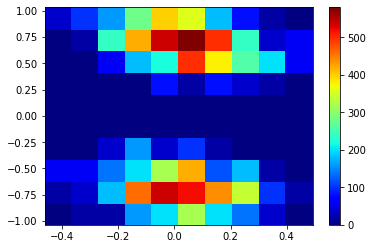

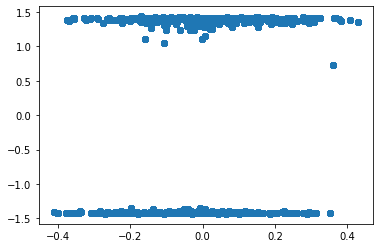

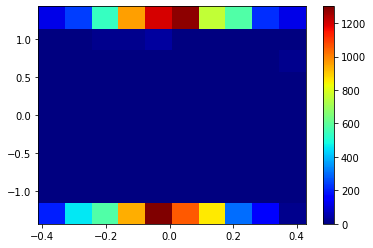

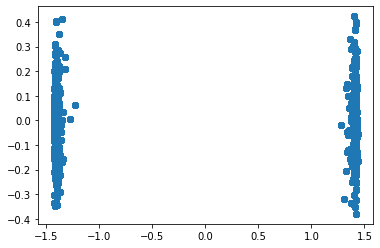

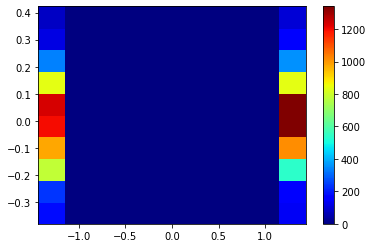

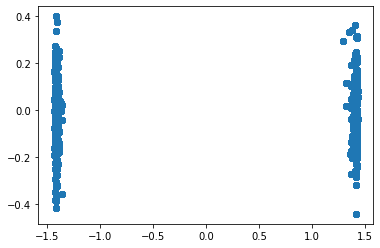

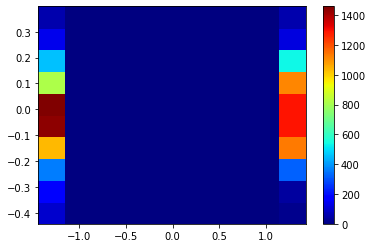

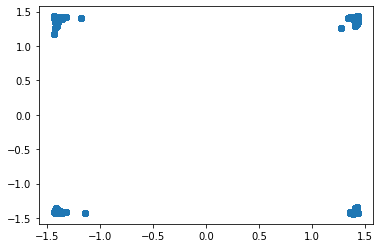

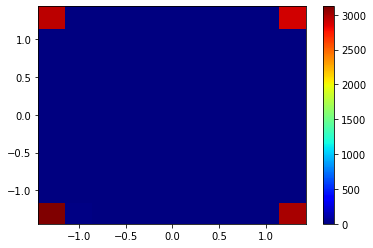

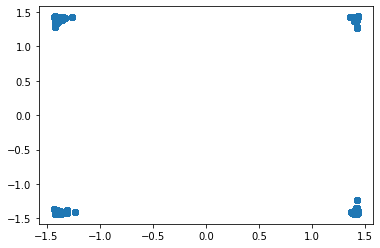

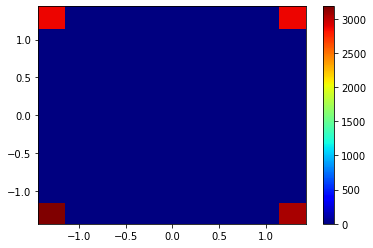

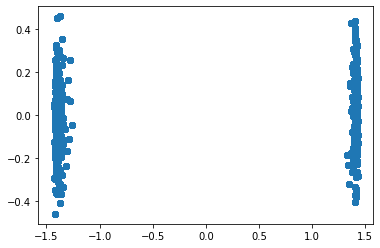

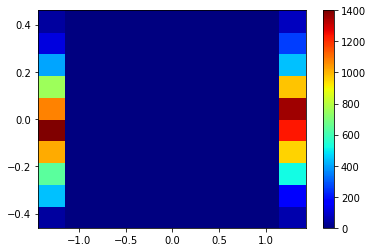

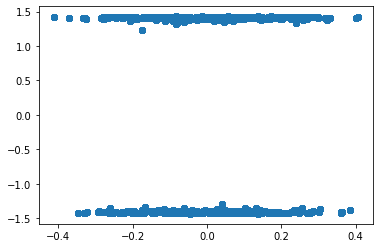

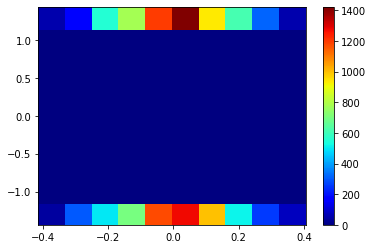

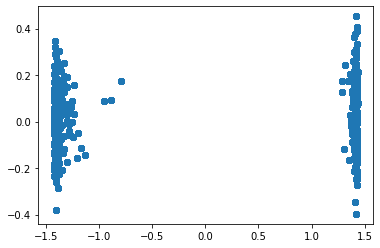

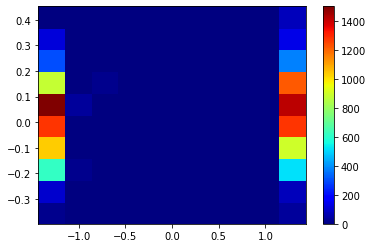

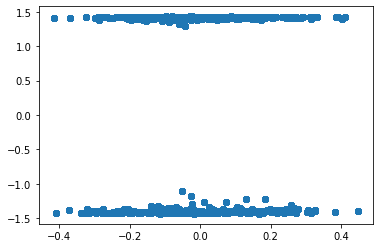

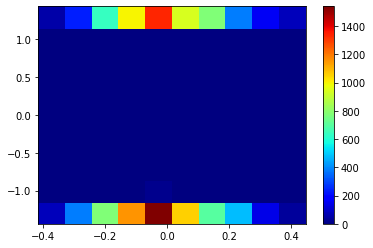

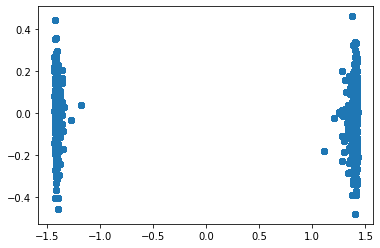

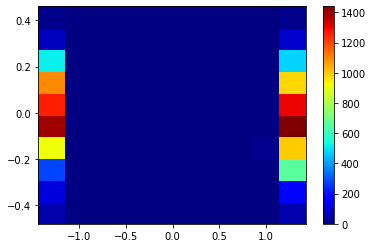

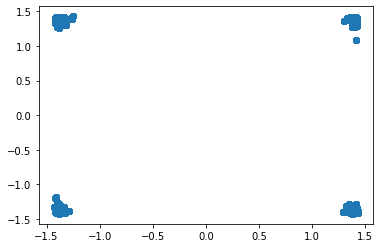

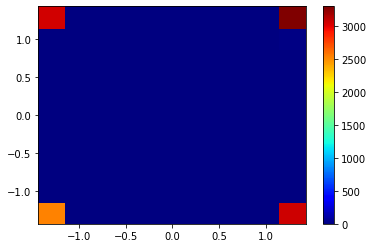

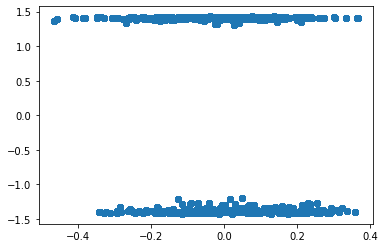

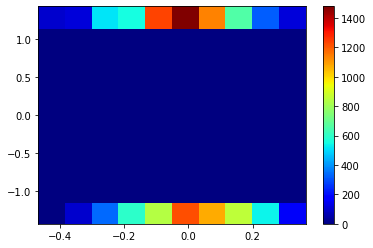

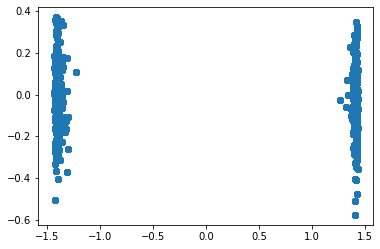

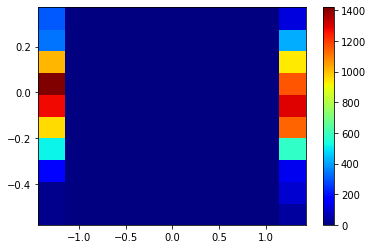

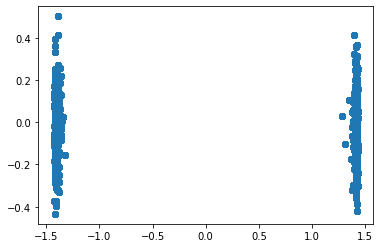

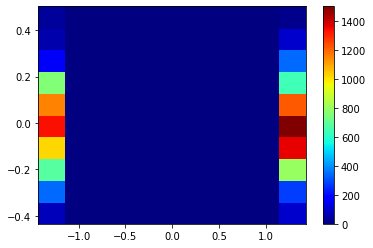

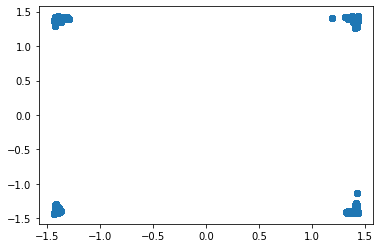

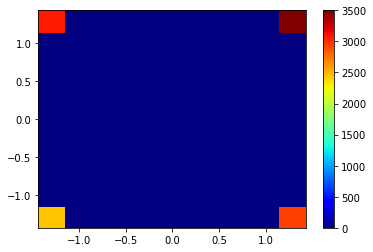

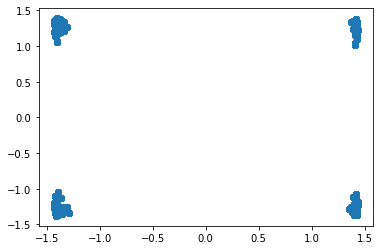

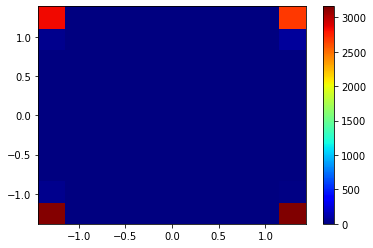

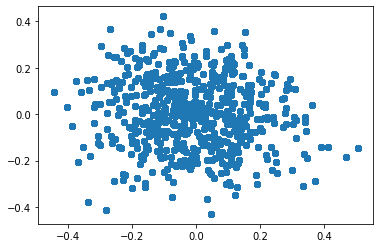

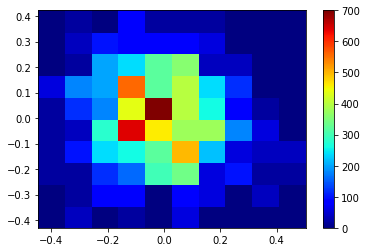

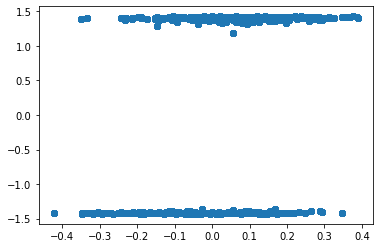

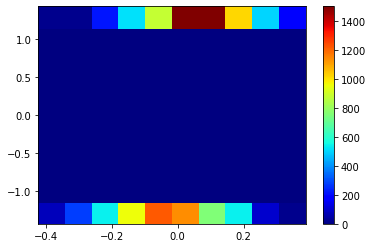

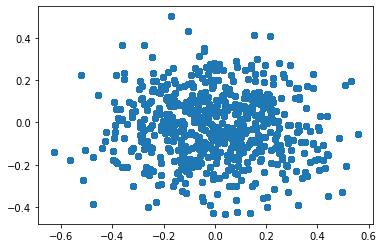

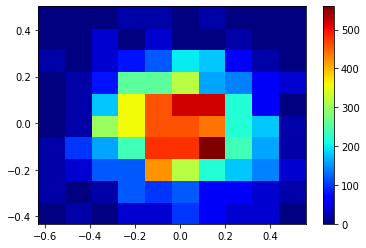

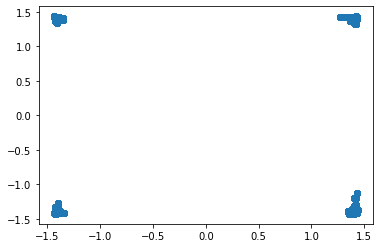

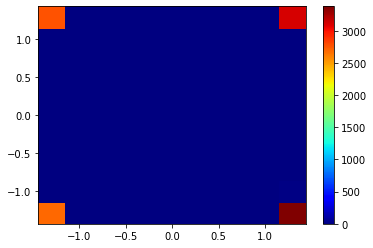

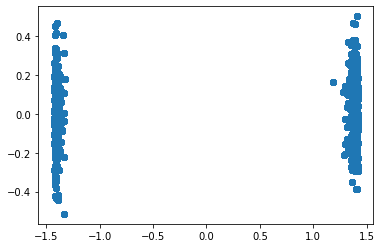

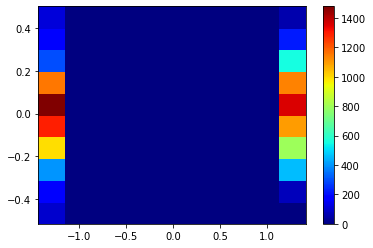

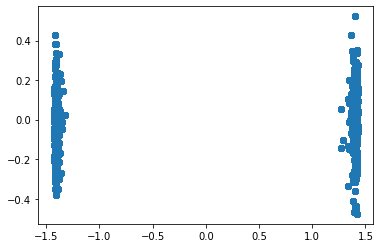

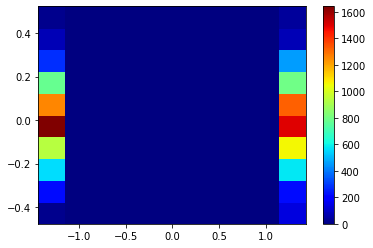

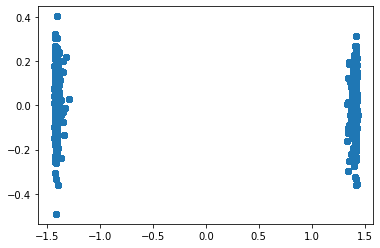

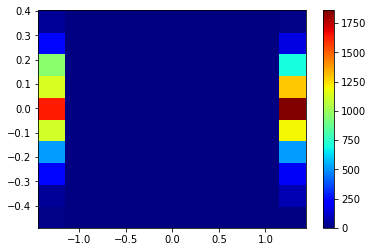

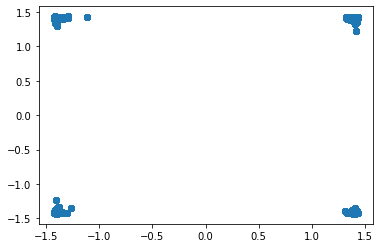

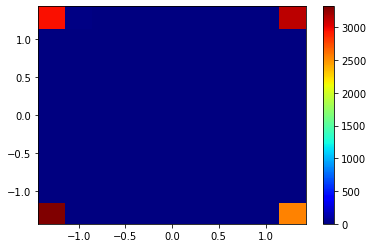

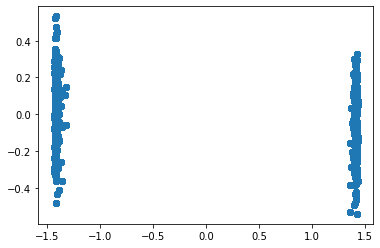

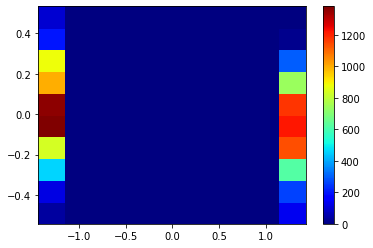

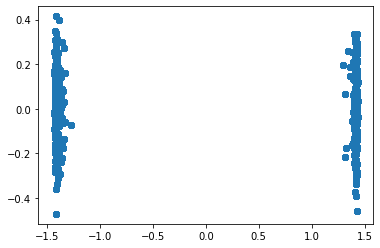

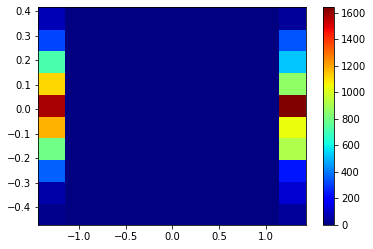

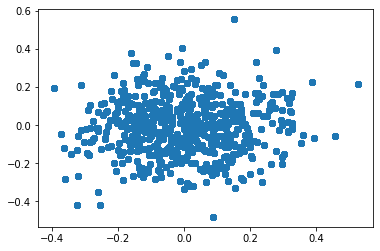

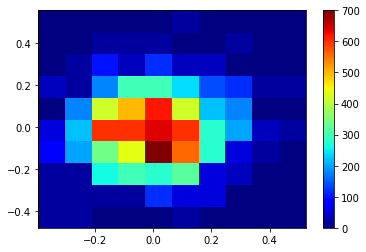

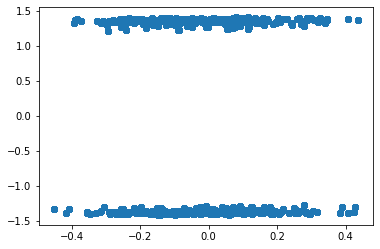

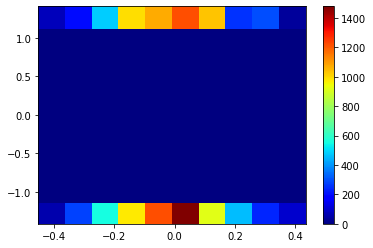

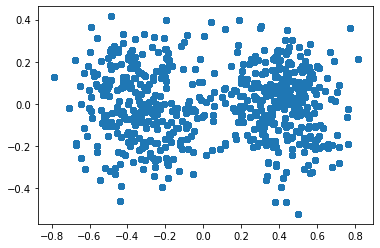

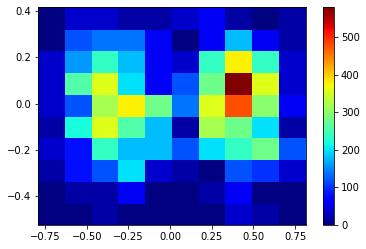

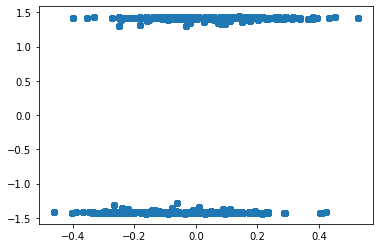

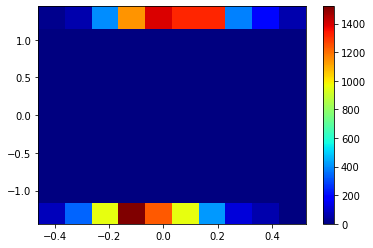

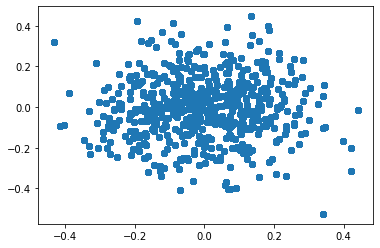

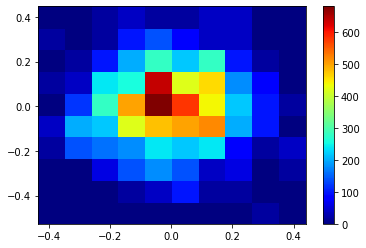

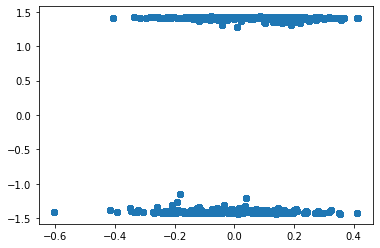

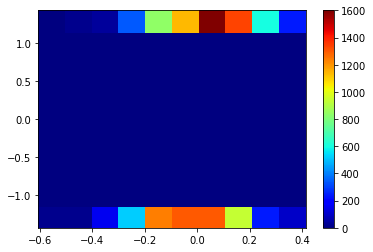

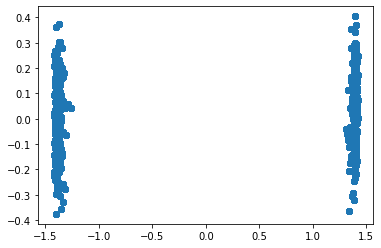

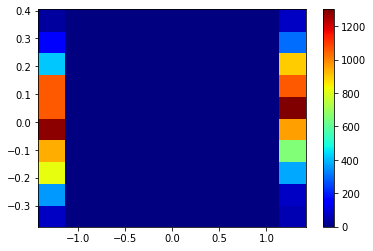

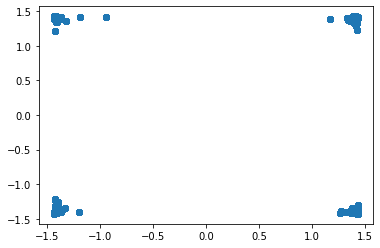

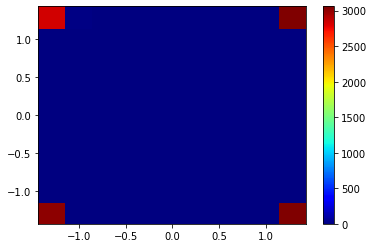

In [12]:
import matplotlib.pyplot as plt
channel_in_array = numpy.transpose(channel_in)

for i in range (int(channel_size)):
  plt.scatter(channel_in_array[i*2], channel_in_array[i*2+1])
  plt.show()
  plt.hist2d(channel_in_array[i*2], channel_in_array[i*2+1], cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()

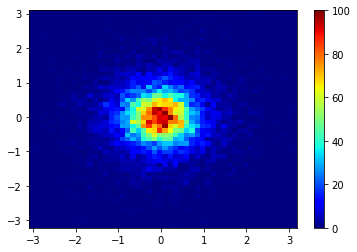

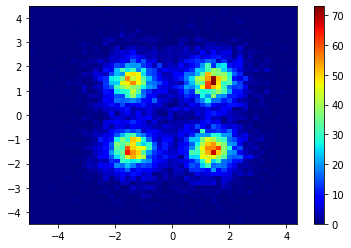

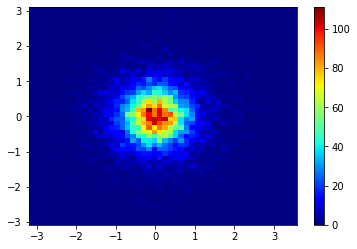

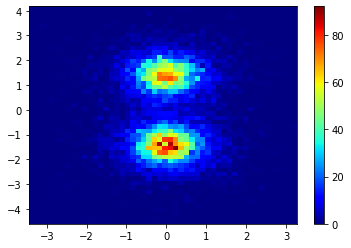

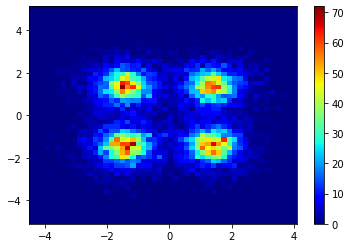

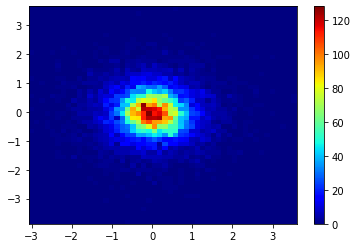

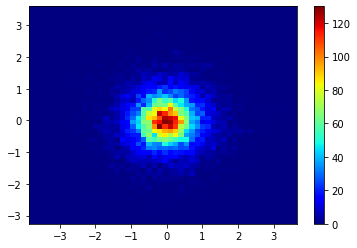

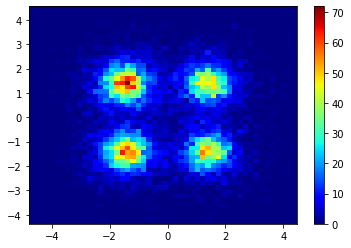

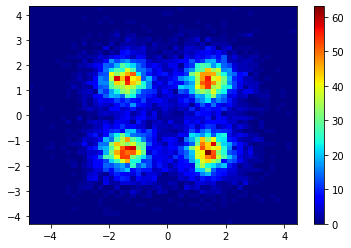

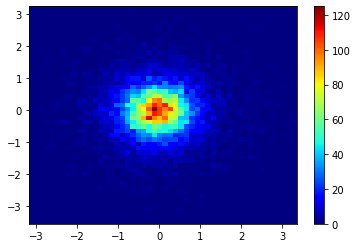

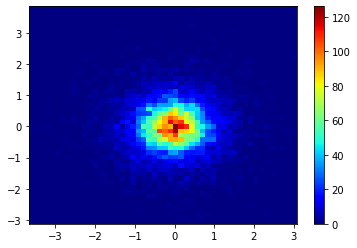

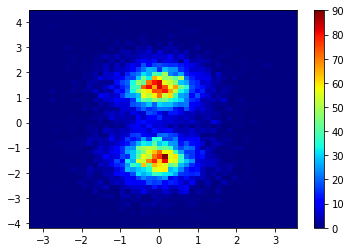

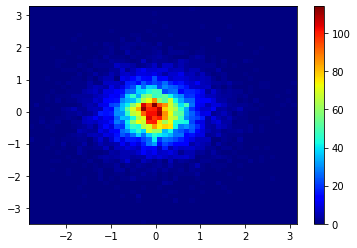

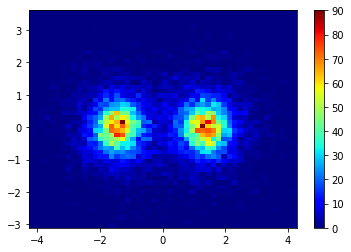

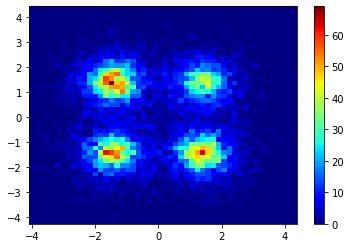

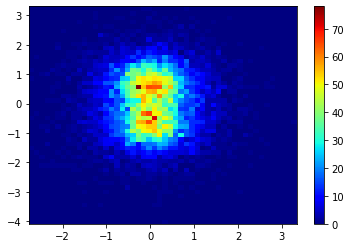

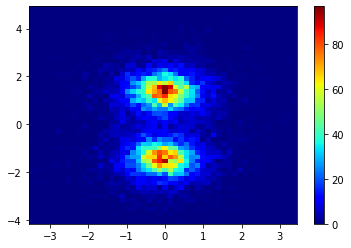

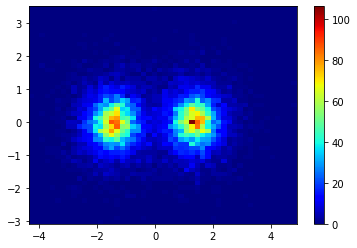

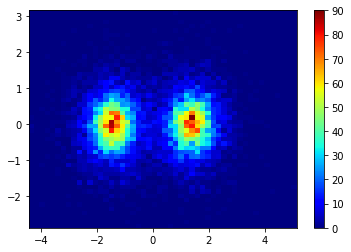

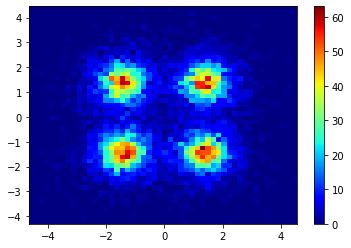

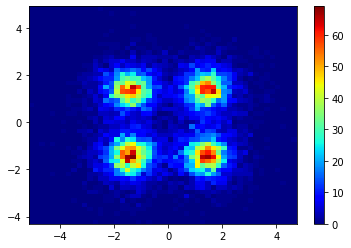

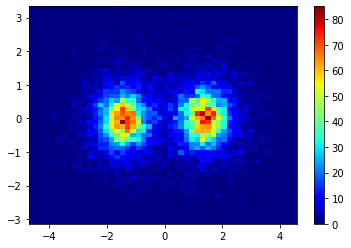

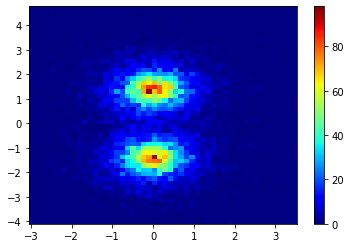

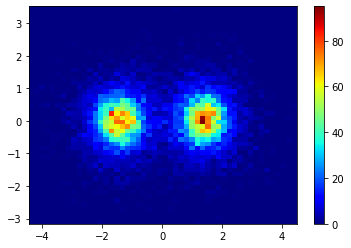

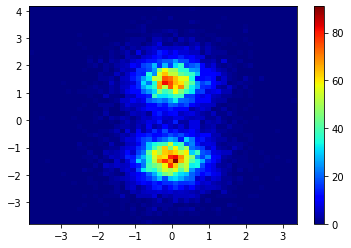

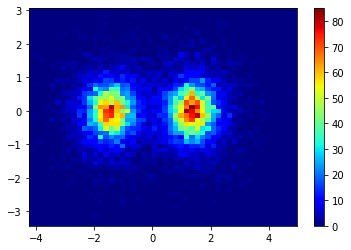

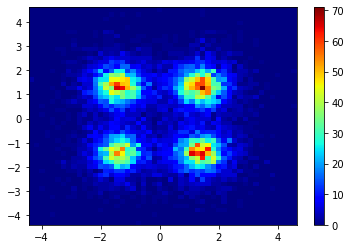

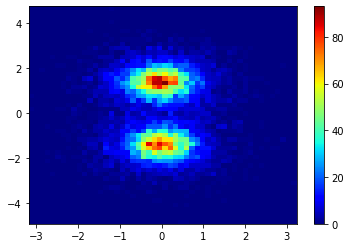

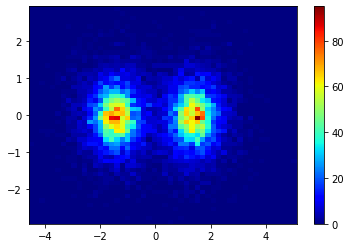

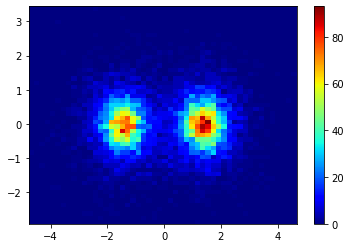

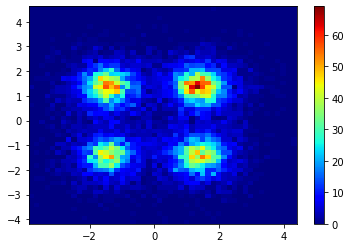

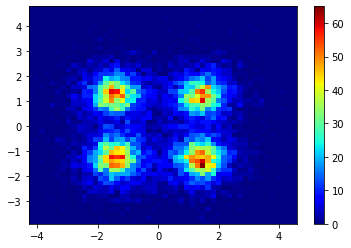

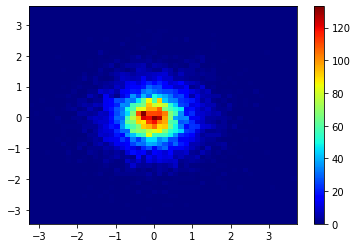

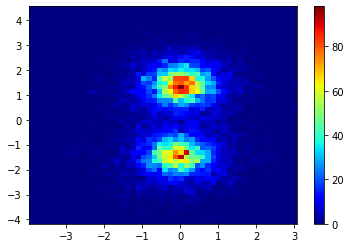

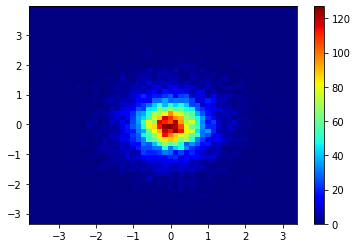

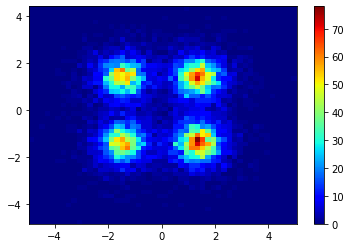

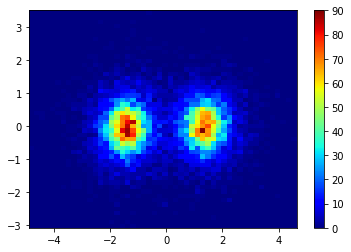

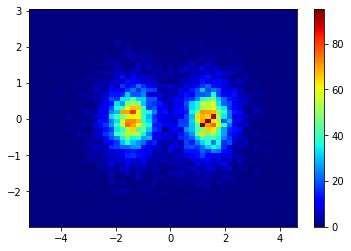

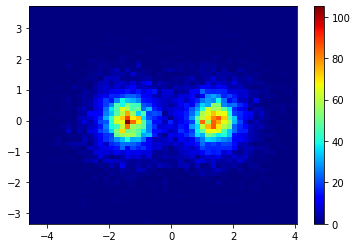

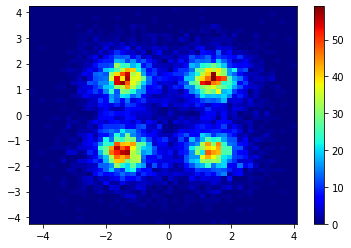

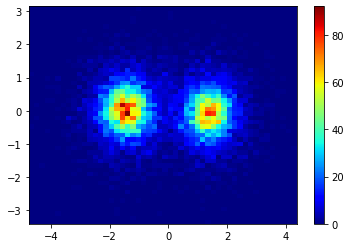

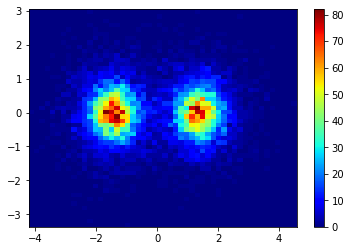

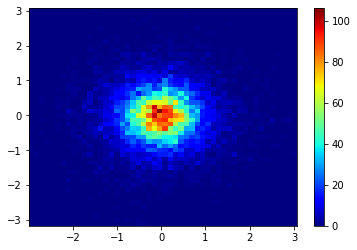

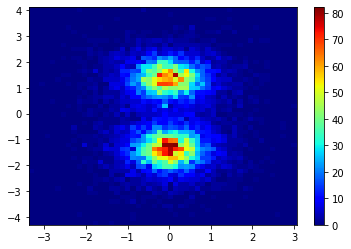

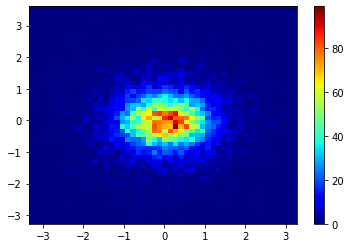

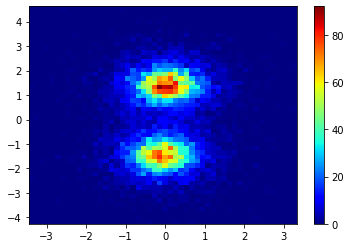

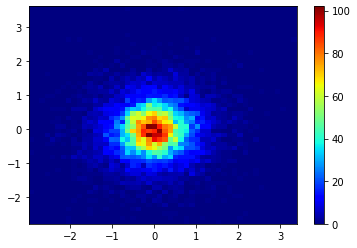

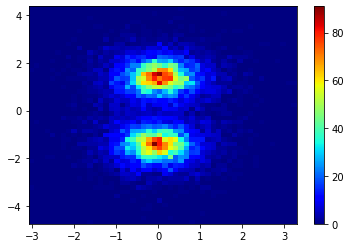

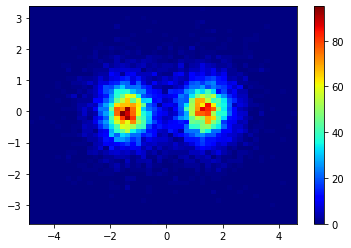

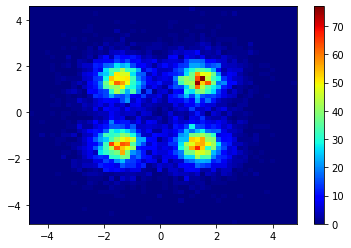

In [13]:
channel_out_array = numpy.transpose(channel_out)

for i in range (int(channel_size)):
  plt.hist2d(channel_out_array[2*i], channel_out_array[2*i+1], (50, 50), cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()

In [14]:
NUM_OF_INPUT_MESSAGE_BER = 600

# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE_BER/4
ber_per_iter_dl_tensor_test  = numpy.array(())
times_per_iter_dl_tensor_test = numpy.array(())

#awgn_channel_tx = GaussianNoise(0.5,input_shape=(channel_size,))


#train_init = tf.global_variables_initializer ()
#train_sess = tf.Session ()

channel_in = []
channel_out = []
test_input_message_int = numpy.around(test_input_message).astype(int)
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE_BER):
    input_message_xx = test_input_message [i:i+1]
    encoded_message = encoder.predict(input_message_xx)
    channel_in.append(encoded_message[0])
    #noised_message = train_sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message[0]})[0].reshape([1,2*channel_size])
    noised_message = encoded_message[0] + numpy.random.normal(0, sigma, [1,2*channel_size])
    channel_out.append(noised_message[0]) 
    decoded_message = decoder.predict(noised_message)
    decoded_message = numpy.around(decoded_message[0]).astype(int)
    if abs(decoded_message-test_input_message_int[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
      #print ("Error")
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE_BER
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor_test=numpy.append(ber_per_iter_dl_tensor_test ,ber)
  times_per_iter_dl_tensor_test=numpy.append(times_per_iter_dl_tensor_test, total_time)

SNR: 0.000 - Iter: 150 - Last 150.0 iterations took 13.58s
SNR: 0.000 - Iter: 300 - Last 150.0 iterations took 27.06s
SNR: 0.000 - Iter: 450 - Last 150.0 iterations took 39.28s
SNR: 0.000 - Iter: 600 - Last 150.0 iterations took 51.53s
SNR: 0.000:
 -> BER: 0.99
 -> Total Time: 131.45s
SNR: 0.500 - Iter: 150 - Last 150.0 iterations took 12.21s
SNR: 0.500 - Iter: 300 - Last 150.0 iterations took 24.28s
SNR: 0.500 - Iter: 450 - Last 150.0 iterations took 36.86s
SNR: 0.500 - Iter: 600 - Last 150.0 iterations took 48.90s
SNR: 0.500:
 -> BER: 0.98
 -> Total Time: 122.25s
SNR: 1.000 - Iter: 150 - Last 150.0 iterations took 12.39s
SNR: 1.000 - Iter: 300 - Last 150.0 iterations took 25.62s
SNR: 1.000 - Iter: 450 - Last 150.0 iterations took 38.59s
SNR: 1.000 - Iter: 600 - Last 150.0 iterations took 51.26s
SNR: 1.000:
 -> BER: 0.96
 -> Total Time: 127.86s
SNR: 1.500 - Iter: 150 - Last 150.0 iterations took 12.27s
SNR: 1.500 - Iter: 300 - Last 150.0 iterations took 24.76s
SNR: 1.500 - Iter: 450 -

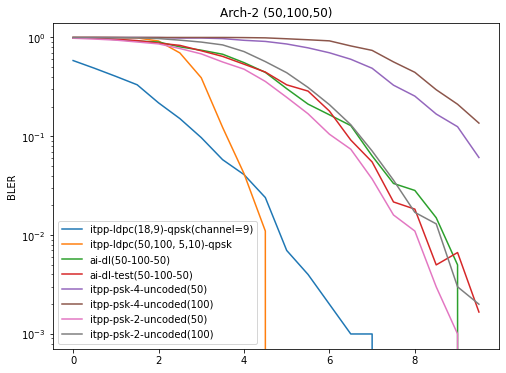

In [15]:
import matplotlib.pyplot as plt
#import numpy
%matplotlib inline
#ber_per_iter_dl_tensor = [.99,.98,.95,.93,.91,.83,.74,.66,.55,.46,.38,.26,.19,.10,.07,.05,.02,0.02,0.01,0.0]
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_4,'', label="itpp-ldpc(18,9)-qpsk(channel=9)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ldpc_50_100_itpp_psk_4,'', label="itpp-ldpc(50,100, 5,10)-qpsk") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl(50-100-50)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor_test,'', label="ai-dl-test(50-100-50)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_50_itpp_psk_4,'', label="itpp-psk-4-uncoded(50)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_100_itpp_psk_4,'', label="itpp-psk-4-uncoded(100)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_50_itpp_psk_2,'', label="itpp-psk-2-uncoded(50)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_100_itpp_psk_2,'', label="itpp-psk-2-uncoded(100)") # plot BER vs SNR
#ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2,'', label="commpy-psk2-uncoded") # plot BER vs SNR
#ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="commpy-psk4-uncoded") # plot BER vs SNR
#ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="itpp-psk2-uncoded") # plot BER vs SNR
#ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham(7,4)(input=8,channel=7)") # plot BER vs SNR
ax1.set_ylabel('BLER')
ax1.set_title('Arch-2 ({},{},{})'.format(input_message_length,2*input_message_length, channel_size))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(2*channel_size,input_message_length))
plt.legend ()
plt.show()